In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve, auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras import optimizers

import tensorflow as tf

import h5py

In [2]:
# mounting  the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path='/content/drive/My Drive/AI ML/Project 8/SVHN_single_grey1.h5';

inp_data = h5py.File(file_path,'r')

data=list(inp_data)
data

['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']

In [4]:
print(type(inp_data))

<class 'h5py._hl.files.File'>


In [0]:
# The text is converted to array
X_test=np.array(inp_data['X_test'])
y_test=np.array(inp_data['y_test'])

X_train=np.array(inp_data['X_train'])
y_train=np.array(inp_data['y_train'])

X_val=np.array(inp_data['X_val'])
y_val=np.array(inp_data['y_val'])

In [6]:
print(X_test.shape)
print(y_test.shape)

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

(18000, 32, 32)
(18000,)
(42000, 32, 32)
(42000,)
(60000, 32, 32)
(60000,)


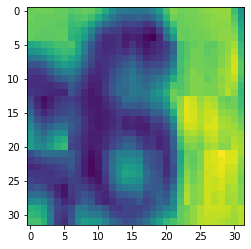

In [7]:
# Plotting the image 

plt.imshow(inp_data['X_train'][20])

Check whether all data has equal count of numbers

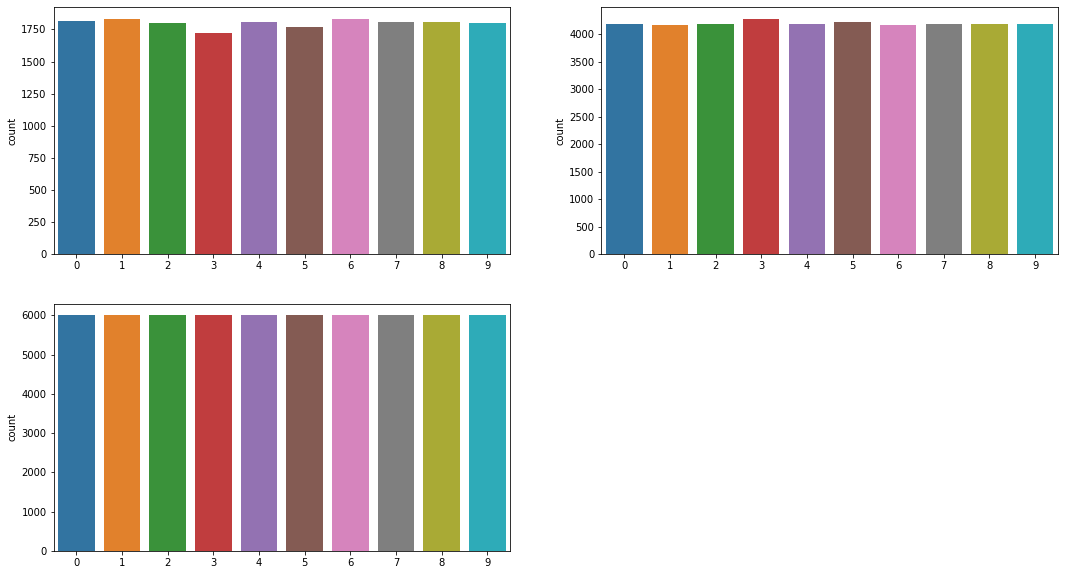

In [8]:
plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
sns.countplot(np.array(inp_data['y_test']))
plt.subplot(2,2,2)
sns.countplot(np.array(inp_data['y_train']))
plt.subplot(2,2,3)
sns.countplot(np.array(inp_data['y_val']))

From above figure, we see that the count of all numbers are same. This means there will no overtraining of a particular class

In [0]:
#Converting the y values to categorical column

y_train=tf.keras.utils.to_categorical(y_train,num_classes=10)
y_test=tf.keras.utils.to_categorical(y_test,num_classes=10)
y_val=tf.keras.utils.to_categorical(y_val,num_classes=10)


In [10]:
print(y_train.shape,y_train[4])

(42000, 10) [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [0]:
# Reshaping input to 1D vector

X_train=X_train.reshape(42000,1024)
X_test=X_test.reshape(18000,1024)
X_val=X_val.reshape(60000,1024)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(42000, 1024)
(18000, 1024)
(60000, 1024)
(42000, 10)
(18000, 10)
(60000, 10)


KNN ALGORITHM:

In [0]:
#RandomizedSearchCV - KNN
#Implement Hyperparameter

def hyper_params_knn(X,y):

    # Create the random grid
    random_grid = {'n_neighbors':[7,10],
                  'leaf_size':[2],
                  'weights':['distance'],
                  'algorithm':['auto'],
                  'n_jobs':[-1]}

    pprint(random_grid)
    return random_grid

def randomizedsearch_knn(X_train,X_test,y_train,y_test):
# Use the random grid to search for best hyperparameters
# First create the base model to tune
    knn = KNeighborsClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = knn, param_distributions = hyper_params_knn(X_train,X_test), n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train, y_train)
    print("Best Hyper Parameters:",rf_random.best_params_)
    
    pred=rf_random.predict(X_test)
    score=rf_random.score(X_test,y_test)
    print("The model prediction is " + str(score*100) + "%")
    print("The confusion matrix is ")
    print(metrics.confusion_matrix(y_test, pred))
    print("the Classification report is")
    print(metrics.classification_report(y_test, pred))

In [26]:
# Since the X_train and X_val count is more, we take only 10k values.
randomizedsearch_knn(X_train[1:10000],X_val[1:10000], y_train[1:10000], y_val[1:10000])

{'algorithm': ['auto'],
 'leaf_size': [2],
 'n_jobs': [-1],
 'n_neighbors': [7, 10],
 'weights': ['distance']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 12.1min finished


Best Hyper Parameters: {'weights': 'distance', 'n_neighbors': 7, 'n_jobs': -1, 'leaf_size': 2, 'algorithm': 'auto'}
The model prediction is 32.87328732873288%
The confusion matrix is 


NameError: ignored

NEURAL NETWORKS:

Lets create a neural networks with One input layer which have 1024(image pixel size) and one hidden layer with 250 neurons. Thus the weight matrix is 250*1024. Since we can have 10 different outputs,the output layer will have 10 neurons

Model Creation:

In [31]:
neural_model=Sequential()

neural_model.add(Dense(250, input_shape = (1024,), activation = 'relu'))
neural_model.add(BatchNormalization())
neural_model.add(Dropout(0.5))
neural_model.add(Dense(10, activation = 'sigmoid'))

obj = optimizers.Adam(lr = 0.01 , beta_1=0.9 , decay =0)
neural_model.compile(optimizer = obj, loss = 'binary_crossentropy', metrics=['accuracy'])
neural_model.summary()

neural_model.fit(X_train, y_train, batch_size = 1000, epochs = 10, verbose = 1,validation_data=(X_val, y_val))
Y_pred_cls = neural_model.predict_classes(X_test, batch_size=200, verbose=0)

print('Accuracy') 
print( str(neural_model.evaluate(X_test,y_test)[1]) )
label=np.argmax(y_test.T, axis=0)
print(confusion_matrix(label, Y_pred_cls))
print(classification_report(Y_pred_cls, label))  

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 250)               256250    
_________________________________________________________________
batch_normalization_2 (Batch (None, 250)               1000      
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2510      
Total params: 259,760
Trainable params: 259,260
Non-trainable params: 500
_________________________________________________________________



Train on 42000 samples, validate on 60000 samples
Epoch 1/10





42000/42000 [==============================] - 6s 140us/step - loss: 0.4440 - acc: 0.8372 - val_loss: 0.7772 - val_acc: 0.6021
Epoch 2/10
42000/42000 [========================

Model Compile:

Lets create another neural networks with One input layer which have 1024(image pixel size) and one hidden layer with 250 neurons,Thus the weight matrix is 250 * 1024 and another hidden layer with 125 neurons. Thus the weight matrix is 125 * 250. Since we can have 10 different outputs,the output layer will have 10 neurons

In [32]:
model = Sequential()

model.add(Dense(250, input_shape = (1024,), activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(125, input_shape = (250,), activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'sigmoid'))

sgd = optimizers.Adam(lr = 0.01 , beta_1=0.9 , decay =0)
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, batch_size = 1000, epochs = 10, verbose = 1,validation_data=(X_val, y_val))
Y_pred_cls = model.predict_classes(X_test, batch_size=200, verbose=0)

print('Accuracy') 
print( str(model.evaluate(X_test,y_test)[1]) )

label=np.argmax(y_test.T, axis=0)
print(confusion_matrix(label, Y_pred_cls))
print(classification_report(Y_pred_cls, label))    


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 250)               256250    
_________________________________________________________________
batch_normalization_3 (Batch (None, 250)               1000      
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 125)               31375     
_________________________________________________________________
batch_normalization_4 (Batch (None, 125)               500       
_________________________________________________________________
dropout_4 (Dropout)          (None, 125)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

Lets create another neural networks with One input layer which have 1024(image pixel size) and one hidden layer with 250 neurons,Thus the weight matrix is 250 * 1024 and another hidden layer with 250 neurons. Thus the weight matrix is 250 * 250. Since we can have 10 different outputs,the output layer will have 10 neurons 

In [33]:
model = Sequential()

model.add(Dense(250, input_shape = (1024,), activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(250, input_shape = (250,), activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(125, input_shape = (250,), activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(10, activation = 'sigmoid'))
sgd = optimizers.Adam(lr = 0.01 , beta_1=0.9 , decay =0)

model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(X_train, y_train, batch_size = 1000, epochs = 50, verbose = 1,validation_data=(X_val, y_val))
Y_pred_cls = model.predict_classes(X_test, batch_size=200, verbose=0)

print('Accuracy') 
print( str(model.evaluate(X_test,y_test)[1]) )


label=np.argmax(y_test.T, axis=0)
print(confusion_matrix(label, Y_pred_cls))
print(classification_report(Y_pred_cls, label))    

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 250)               256250    
_________________________________________________________________
batch_normalization_5 (Batch (None, 250)               1000      
_________________________________________________________________
dropout_5 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 250)               62750     
_________________________________________________________________
batch_normalization_6 (Batch (None, 250)               1000      
_________________________________________________________________
dropout_6 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 125)              

1
4


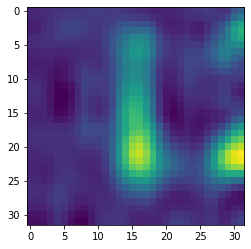

In [35]:
plt.imshow(X_test[56].reshape(32,32))
print(label[56])
print(Y_pred_cls[56])

2
2


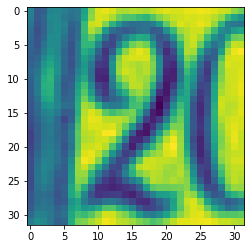

In [36]:
plt.imshow(X_test[66].reshape(32,32))
print(label[66])
print(Y_pred_cls[66])

CONCLUSION:

From the figures, we see that the numbers 1,4,7 are confusing for the model.

When compared to normal ML algorithm(KNN), Neural networks perform well due to its feature extraction compatibility.